In [1]:
import os
import glob
import re
import shutil
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import pandas as pd
from PIL import Image
import tciaclient
import pandas
import zipfile
import multiprocessing as mp
import pylidc as pl

In [2]:
def getResponseString(response):
    if response.getcode() is not 200:
        raise ValueError("Server returned an error")
    else:
        return response.read()

In [3]:
api_key = "16ade9bc-f2fa-4a37-b357-36466a0020fc"
baseUrl="https://services.cancerimagingarchive.net/services/v3"
resource = "TCIA"

In [4]:
client = tciaclient.TCIAClient(baseUrl, resource)

In [5]:
response = client.get_series(modality="CT", collection="LIDC-IDRI")#, bodyPartExamined="CHEST")
strRespSeries = getResponseString(response)

df = pandas.io.json.read_json(strRespSeries)
print(df["Modality"].unique())

['CT']


In [6]:
labels=pd.read_csv("/mnt/idms/PROJECTS/Lung/LIDC_IDRI/Labels/LIDC-IDRI_MetaData.csv")
labels=labels.rename(columns={"Study UID":"StudyInstanceUID"})
df=df.merge(labels,on="StudyInstanceUID")[["SeriesInstanceUID","Subject ID"]]

In [7]:
downloadPath="/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/"

In [42]:
def download_zip(ids):
    (uid,sid)=ids
    zipFileName=f"LIDC_IDRI_{sid}.zip"
    if not os.path.exists(f"{downloadPath}{zipFileName}"):
        print(f"{downloadPath}{zipFileName}")
        response = client.get_image(uid,downloadPath,zipFileName)

In [43]:
pool = mp.Pool(80)
pool.map(download_zip, zip(list(df["SeriesInstanceUID"]),df["Subject ID"]))

/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0376.zip
/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0308.zip
/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0406.zip/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0655.zip/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0665.zip/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0490.zip/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0876.zip/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0941.zip/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0651.zip/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0963.zip/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0469.zip/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0328.zip/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0722.zip












[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [8]:
a="jfkldjfdklsfjdklsf.zip"
a[-4:]

'.zip'

In [14]:
import subprocess

In [49]:
def my_remove(p):
    shutil.rmtree(p)

In [50]:
pool = mp.Pool(80)
pool.map(my_remove, glob.glob("/mnt/idms/PROJECTS/Lung/LIDC_IDRI/*"))

NotADirectoryError: [Errno 20] Not a directory: '/mnt/idms/PROJECTS/Lung/LIDC_IDRI/tciaclient.py'

In [44]:
def unzip_LIDC(sid):
    if not os.path.exists(f"{downloadPath}{sid}"):
        try:
            print(f"{downloadPath}LIDC_IDRI_{sid}.zip GOOOOOD")
            with zipfile.ZipFile(f"{downloadPath}LIDC_IDRI_{sid}.zip", 'r') as zip_ref:
                zip_ref.extractall(f"{downloadPath}{sid}")
        except:
            os.remove(f"{downloadPath}LIDC_IDRI_{sid}.zip")
            print(f"{downloadPath}LIDC_IDRI_{sid}.zip ERROR")
            #raise

In [45]:
pool = mp.Pool(80)
pool.map(unzip_LIDC, list(df["Subject ID"]))

/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0328.zip GOOOOOD/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0376.zip GOOOOOD/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0876.zip GOOOOOD/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0651.zip GOOOOOD/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0308.zip GOOOOOD/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0490.zip GOOOOOD/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0941.zip GOOOOOD/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0469.zip GOOOOOD/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0406.zip GOOOOOD/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0655.zip GOOOOOD/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0722.zip GOOOOOD/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0963.zip GOOOOOD/mnt/idms/PROJECTS/Lung/LIDC_IDRI2/LIDC_IDRI_LIDC-IDRI-0665.zip GOOOOOD














[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
filename = "/mnt/idms/PROJECTS/Lung/Kaggle-data/cancer_cases/home/peter/lung/data/stage1/stage1/229b8b785f880f61d8dad636c3dc2687/f1a23adea3019e89e938f9de24887ae6.dcm"
ds = pydicom.dcmread(filename)
print((ds.pixel_array).shape)

plt.imshow(ds.pixel_array, cmap=plt.cm.bone)

data_img = Image.fromarray(ds.pixel_array)
data_img_rotated = data_img.rotate(angle=45,resample=Image.BICUBIC,fillcolor=data_img.getpixel((0,0)))
print(type(data_img_rotated))
plt.imshow(data_img_rotated)

In [ ]:
from PIL import Image
data_img = Image.fromarray(ds.pixel_array)
data_img_rotated = data_img.rotate(angle=45,resample=Image.BICUBIC,fillcolor=data_img.getpixel((0,0)))

In [ ]:
filename_lymp = "/mnt/idms/PROJECTS/Lung/LymphoglandulaeMetastasis/SE000006/50848-0584.dcm"
filename_lung="/mnt/idms/PROJECTS/Lung/LungMetastasis/SE000004/54680-0545.dcm"
lidc="/mnt/idms/PROJECTS/Lung/LIDC_Proba/318-06a33f72aef6dc0e3b645cd7a50610a6.dcm"
ds = pydicom.dcmread(lidc)
#print((ds.pixel_array).shape)

plt.imshow(ds.pixel_array, cmap=plt.cm.bone)

#data_img = Image.fromarray(ds.pixel_array)
#data_img_rotated = data_img.rotate(angle=45,resample=Image.BICUBIC,fillcolor=data_img.getpixel((0,0)))
#print(type(data_img_rotated))
#plt.imshow(data_img)

In [ ]:
no_num=len(glob.glob('./NoMetastasis/*.txt'))
lung_num=len(glob.glob('./LungMetastasis/*.txt'))
lymp_num=len(glob.glob('./LymphoglandulaeMetastasis/*.txt'))
ct_num=no_num+lung_num+lymp_num

In [ ]:
lung_labels=np.asarray([0]*no_num+[1]*lung_num+[0]*lymp_num).astype(np.float32)
lymp_labels=np.asarray([0]*no_num+[0]*lung_num+[1]*lymp_num).astype(np.float32)

print(lung_labels)

print(lung_labels.shape)
#for filename in glob.glob('./Tudo-Ulyssys/*.txt'):
#    with open(filename, 'r', encoding='latin1', errors='ignore') as file:

## Pylidc API

Loading dicom files ... This may take a moment.


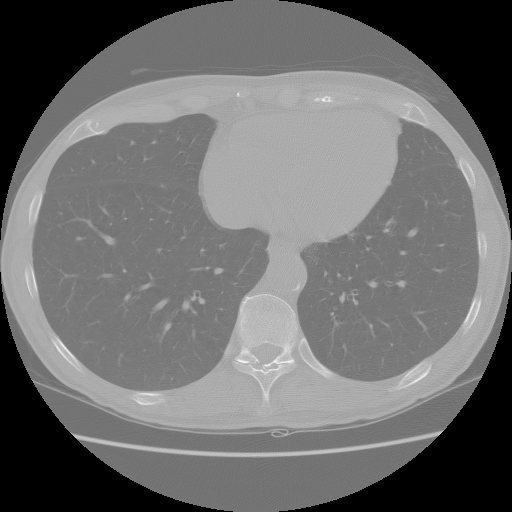

In [71]:
scan=list(pl.query(pl.Scan))[1011]
img_np=scan.to_volume()[:,:,40]
maxi=np.max(img_np)
mini=np.min(img_np)
img_np=((img_np-mini)/(maxi-mini))*255
Image.fromarray(img_np).show()

In [ ]:
for scan in pl.query(pl.Scan):
    print(scan)
    #print(scan.cluster_annotations())
    Image.fromarray(scan.to_volume()).show()
    break

In [ ]:
scans.count()

In [ ]:
vars(pl.Scan.scan)

In [ ]:
path="/mnt/idms/PROJECTS/Lung/LIDC_IDRI/LIDC_IDRI_1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029"

In [ ]:
for dcm in glob.glob(f"{path}/*.dcm"):
    print(pydicom.read_file(dcm))

In [ ]:
path="/mnt/idms/PROJECTS/Lung/LIDC_IDRI/"
for ct_path in glob.glob(f"{path}/LIDC_IDRI*"):
    print(ct_path)
    first_dcm=glob.glob(f"{ct_path}/*")[0]
    patient_id=pydicom.read_file(first_dcm).PatientID
    subprocess.call(["mv", ct_path, os.path.join(path,patient_id)])
    print(os.path.join(path,patient_id))
    #move(ct_path,os.path.join(path,patient_id))

In [ ]:
import subprocess

In [ ]:
from os import subprocess